# Create training dataset for size normalization networks

Decisions to be made:
- sex. starting with ~~females~~
- age. ~~9wks for now~~ - switching to males, 3 months
- one mouse vs many. Using many mice

In [1]:
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster

In [2]:
# path = Path('/home/wg41/groups/Dana/Ontogeny/raw_data/Ontogeny_females/9wks')
path = Path('/home/wg41/groups/Dana/Ontogeny/raw_data/Ontogeny_males/3months_19042021')
training_data_path = Path('/n/groups/datta/win/longtogeny/data/size_network/training_data')

In [3]:
files = sorted(path.glob('**/results_00.h5'))

In [4]:
def zscore(df):
    return (df - df.mean()) / df.std()

In [5]:
# open the files, get width/length/height of all sessions
morph_stats = []
for file in files:
    with h5py.File(file, 'r') as h5f:
        a = np.nanmedian(h5f['scalars/area_mm'])
        morph_stats.append(dict(
            area=a,
            file=str(file),
        ))
morph_stats = pd.DataFrame(morph_stats)

In [6]:
morph_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   area    24 non-null     float32
 1   file    24 non-null     object 
dtypes: float32(1), object(1)
memory usage: 416.0+ bytes


In [7]:
dists = pdist(morph_stats[['area']])

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


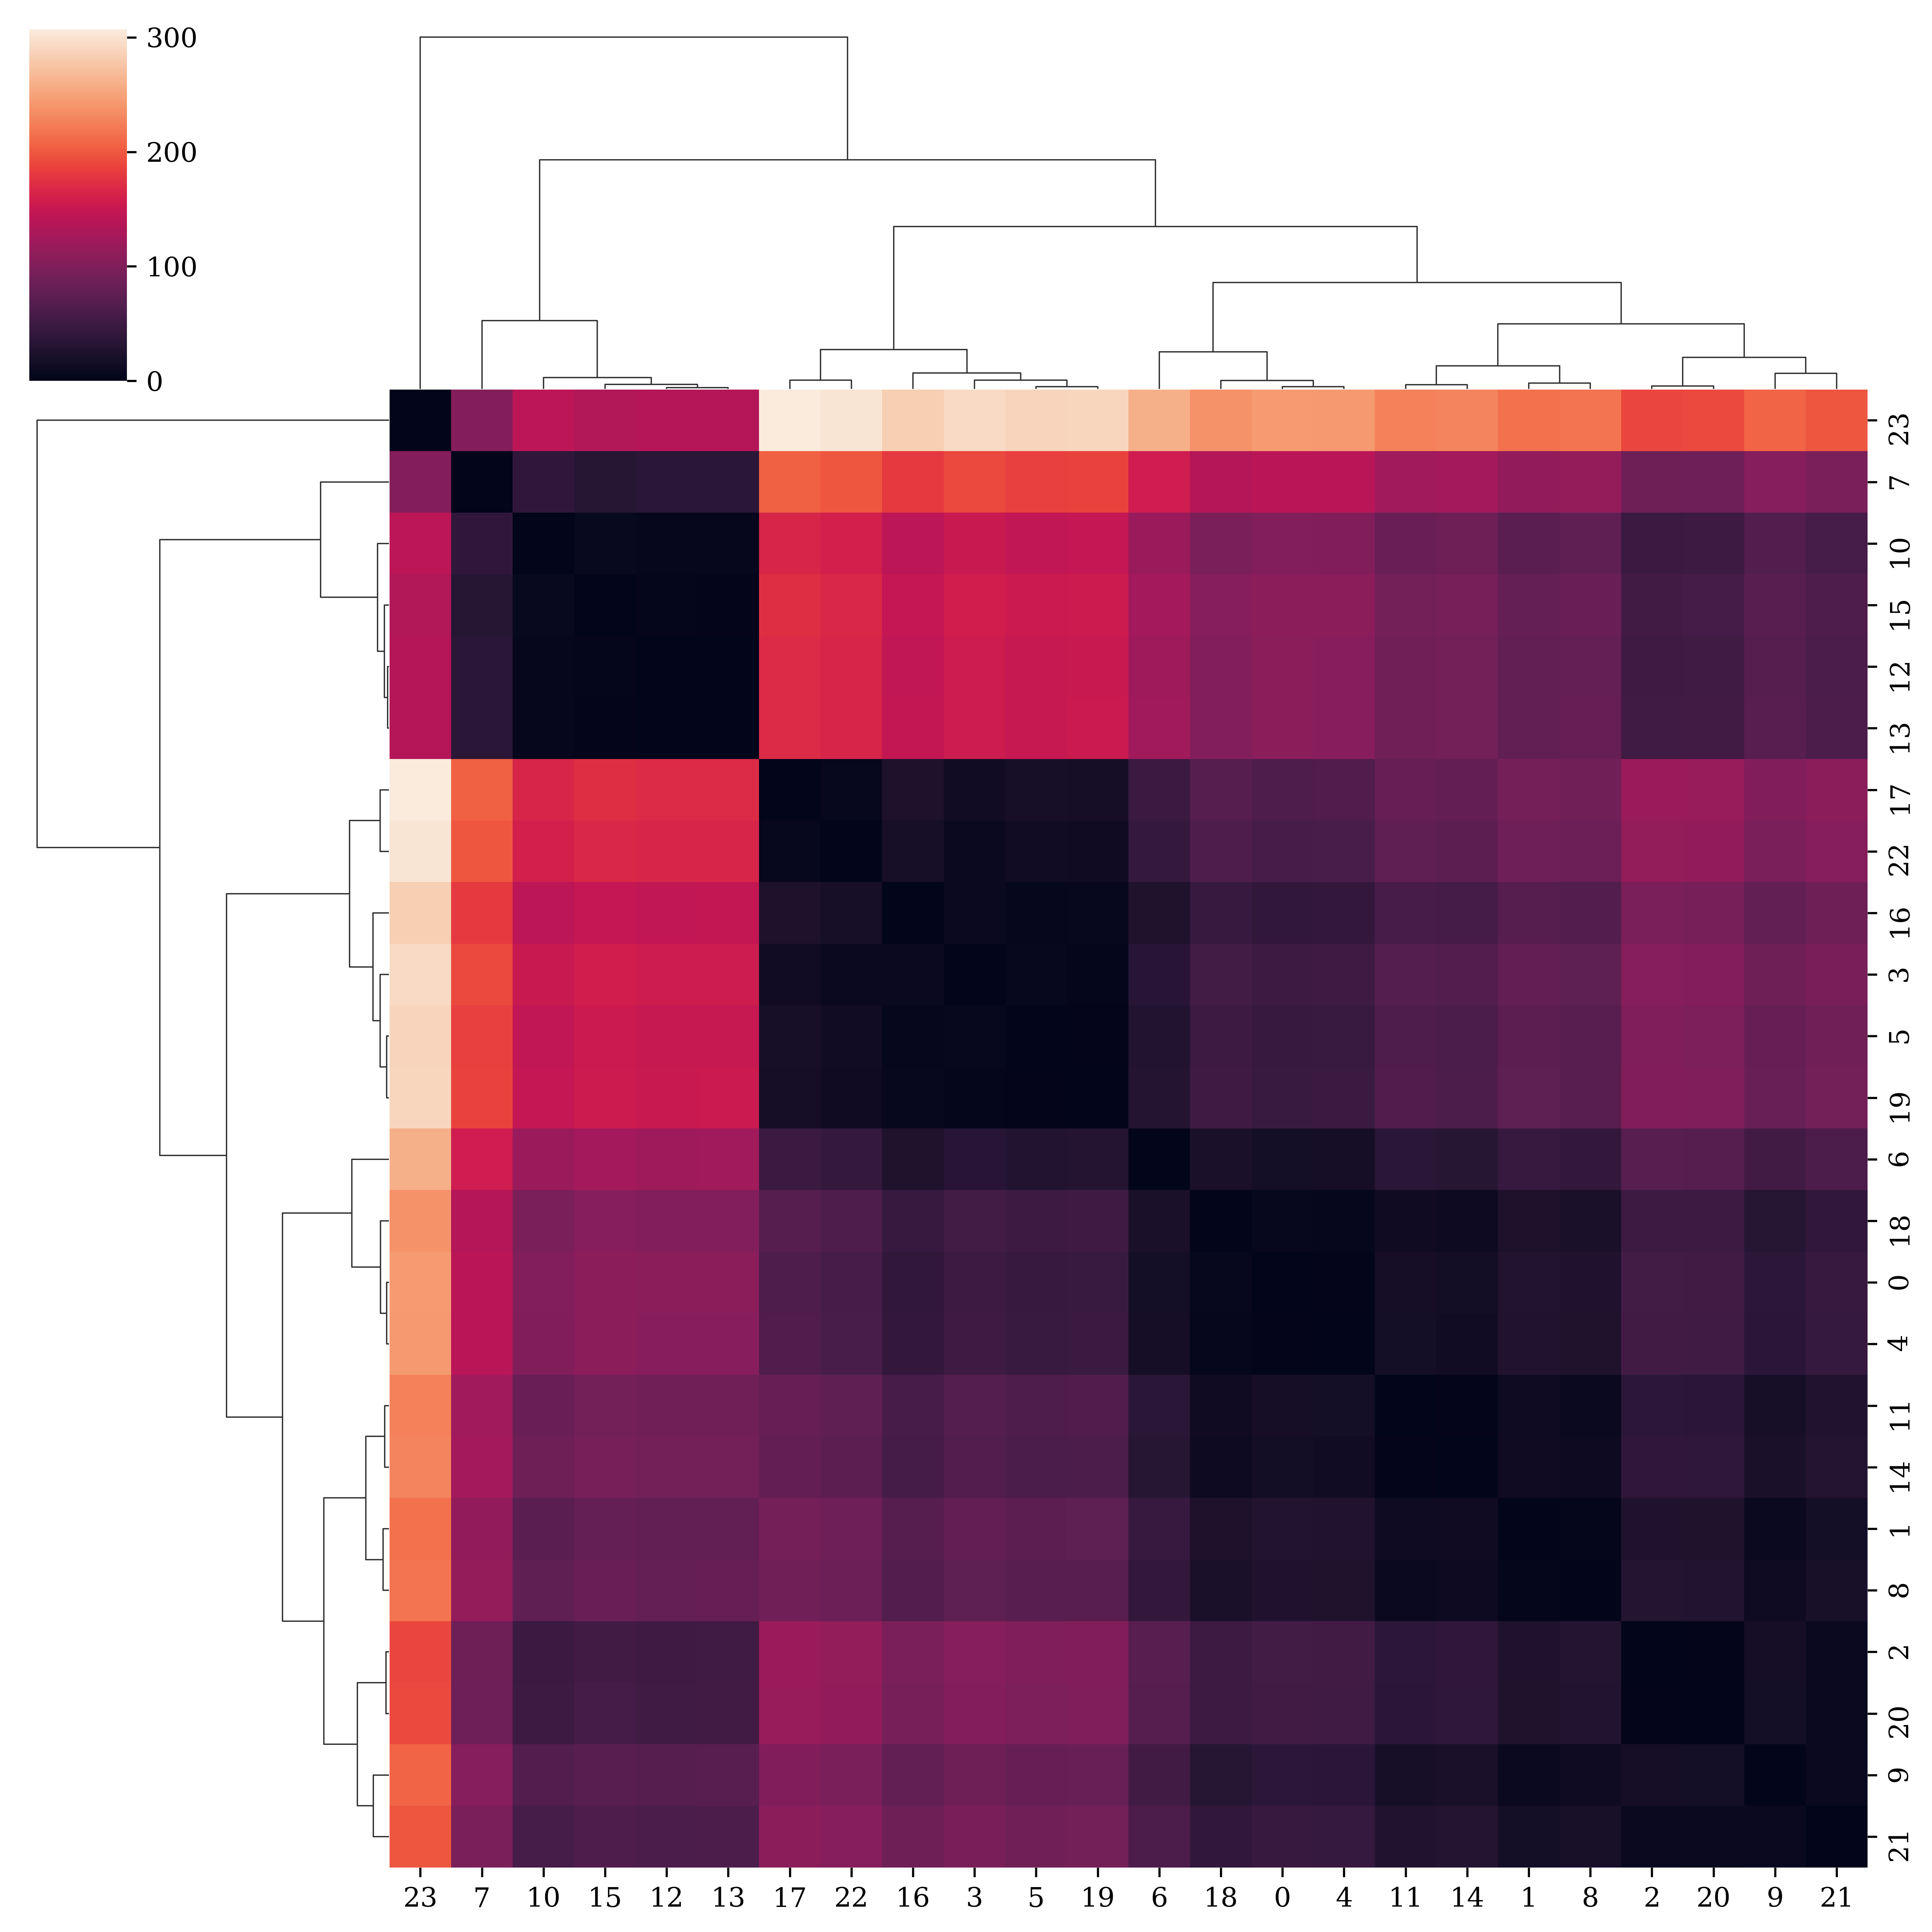

In [8]:
cg = sns.clustermap(squareform(dists), method='complete')

In [9]:
lbls = fcluster(cg.dendrogram_row.linkage, t=5, criterion='maxclust')
lbls

array([3, 4, 4, 2, 3, 2, 3, 1, 4, 4, 1, 4, 1, 1, 4, 1, 2, 2, 3, 2, 4, 4,
       2, 5], dtype=int32)

In [10]:
np.bincount(lbls)

array([0, 5, 6, 4, 8, 1])

In [13]:
## assert that these sessions are the same as the largest group in the heatmap above
sessions = np.where(lbls == 4)[0]
sessions

array([ 1,  2,  8,  9, 11, 14, 20, 21])

In [12]:
len(sessions)

8

In [14]:
frames = []
for file in tqdm(map(lambda x: files[x], sessions)):
    with h5py.File(file, 'r') as h5f:
        frames.append(h5f['frames'][()])
frames = np.concatenate(frames, axis=0)
len(frames)

0it [00:00, ?it/s]

431090

## Run K-means clustering to sub-select the data

In [15]:
from sklearn.cluster import k_means
from sklearn.decomposition import PCA
from toolz import sliding_window

In [16]:
# subselect frames for pca
np.random.seed(0)
indices = np.random.permutation(np.arange(len(frames)))[:50_000]
pca = PCA(n_components=25).fit(frames[indices].reshape(len(indices), -1))

In [17]:
pcs = []
for batch in sliding_window(2, list(range(0, len(frames), 4000)) + [len(frames)]):
    pcs.append(pca.transform(frames[slice(*batch)].reshape(batch[1] - batch[0], -1)))

In [18]:
pcs = np.concatenate(pcs, axis=0)

In [19]:
pcs.shape

(431090, 25)

In [20]:
centers, labels, *_ = k_means(pcs, n_clusters=30, random_state=0)

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
centers.shape

(30, 25)

In [22]:
labels.shape

(431090,)

In [23]:
lbls = pd.Series(labels)

In [24]:
lbls.value_counts()

1     35335
5     34535
17    30428
24    29874
11    28751
26    27287
7     22780
16    21571
29    21346
10    21004
12    20266
23    13999
28    13348
9     12848
0     10345
8      9309
14     8808
15     8072
13     6998
6      6598
22     6204
2      5801
27     5463
18     5380
25     4941
4      4578
21     4417
19     3810
20     3689
3      3305
Name: count, dtype: int64

In [25]:
# get same number of each "class"
sample = lbls.groupby(lbls).apply(lambda v: v.sample(n=3300, random_state=0)).droplevel(0)

In [26]:
examples = sample.groupby(sample).apply(lambda v: np.nanmedian(frames[v.index], axis=0))

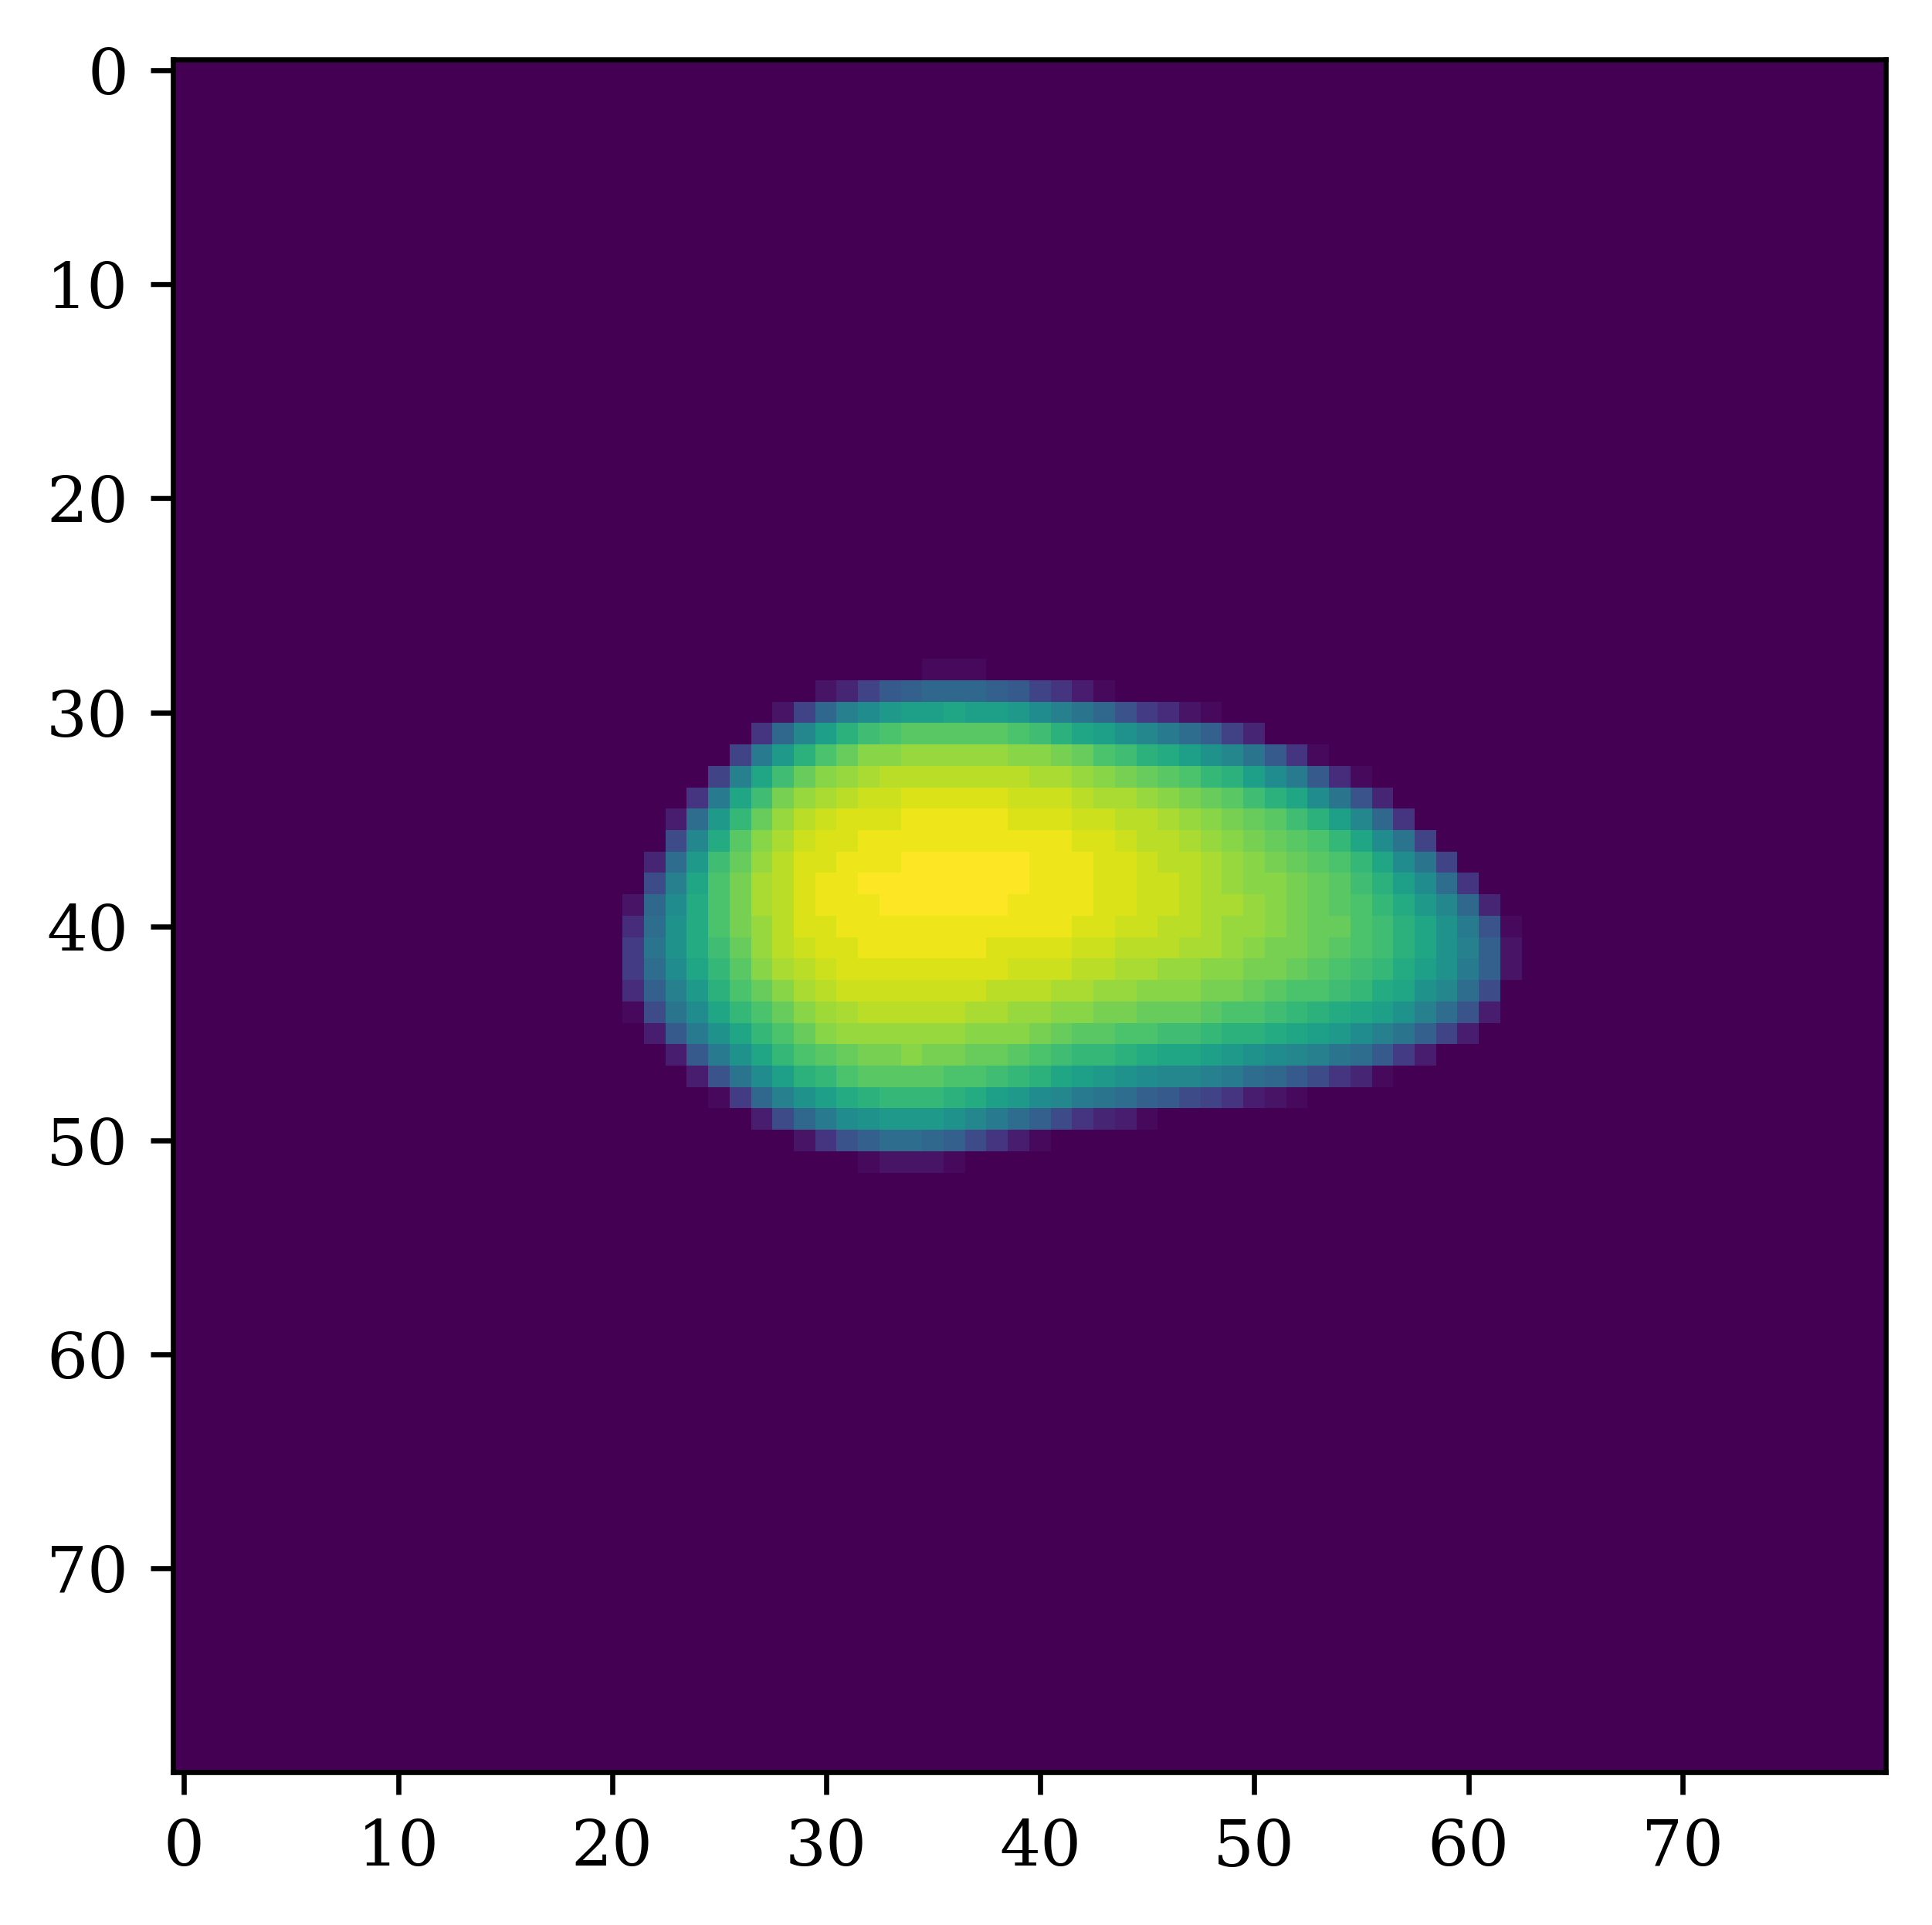

In [58]:
# get rid of 3, 27?
plt.imshow(examples[29])

In [59]:
# keep these frames
keep_indices = np.sort(sample[~sample.isin([3, 27])].index)

In [60]:
keep_frames = frames[keep_indices]

In [61]:
keep_frames.shape

(92400, 80, 80)

In [62]:
with h5py.File(training_data_path / '3month-male-multi_animal_training_data.h5', 'w') as h5f:
    h5f.create_dataset('training_frames', data=keep_frames, compression='gzip')